In [3]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np

[*********************100%***********************]  1 of 1 completed


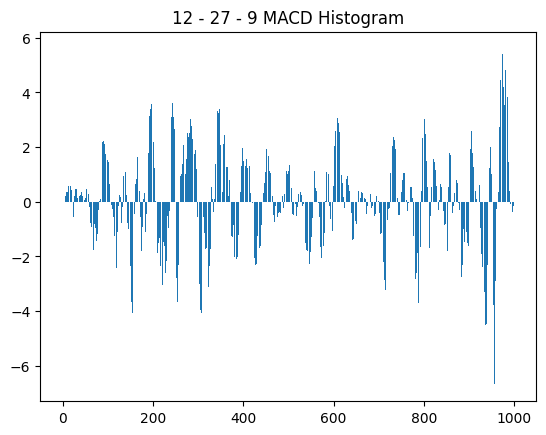

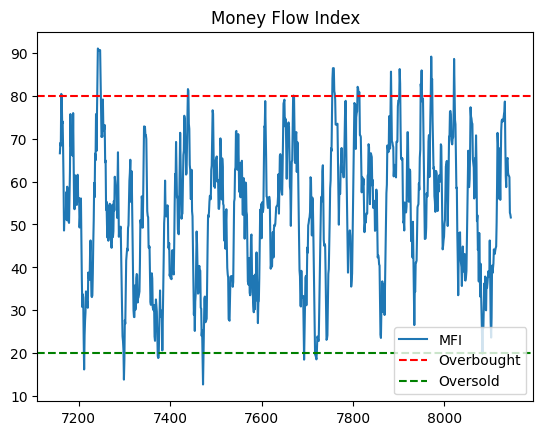

Price,Close,High,Low,Open,Volume,12_ema,27_ema,MACD,Signal,MACD_hist,...,Price_Change,Pos_Flow,Neg_Flow,MFI,MACD_Strategy,MFI_Strategy,Full_Strategy,Strategy,Asset_Returns,Strategy_Returns
7159,410.322510,411.346129,407.555008,411.128129,68710400,405.971751,404.462669,1.509082,0.935646,0.573436,...,-0.439188,0.000000e+00,2.815348e+10,66.576824,NaN,NaN,NaN,0,NaN,NaN
7160,411.772705,412.057057,408.976770,411.014492,63549500,406.943510,405.240859,1.702651,1.094641,0.608010,...,1.194295,2.611475e+10,0.000000e+00,69.010706,1.0,-1.0,0.0,0,0.003534,0.000000
7161,408.417480,409.185180,405.195004,406.389217,97595200,407.187095,405.567582,1.619513,1.202656,0.416857,...,-3.336289,0.000000e+00,3.977973e+10,68.330449,1.0,-1.0,0.0,0,-0.004643,0.000000
7162,412.777313,413.080610,408.218492,409.943459,76238600,408.100499,406.286528,1.813971,1.327735,0.486235,...,3.759583,3.136142e+10,0.000000e+00,80.410317,1.0,-1.0,0.0,0,0.005983,0.000000
7163,414.255890,414.511809,412.256087,412.692058,52889600,409.096737,407.059361,2.037377,1.472267,0.565110,...,2.315790,2.187908e+10,0.000000e+00,80.003235,1.0,-1.0,0.0,0,0.009586,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8141,596.090027,597.080017,591.849976,592.340027,63606200,587.763075,578.004709,9.758366,9.891258,-0.132892,...,4.820007,3.784611e+10,0.000000e+00,61.301648,-1.0,-1.0,-2.0,-1,0.452735,-0.030831
8142,595.929993,597.950012,595.489990,596.960022,57314200,589.019524,579.285087,9.734438,9.859894,-0.125456,...,1.449992,3.418544e+10,0.000000e+00,60.990442,-1.0,-1.0,-2.0,-1,0.452345,-0.030571
8143,593.049988,599.000000,591.049988,597.630005,92278700,589.639596,580.268294,9.371302,9.762176,-0.390874,...,-2.090007,0.000000e+00,5.484738e+10,52.731204,-1.0,-1.0,-2.0,-1,0.445326,-0.025886
8144,599.140015,600.830017,596.859985,598.659973,66588700,591.101199,581.616274,9.484925,9.706725,-0.221801,...,4.576681,3.988286e+10,0.000000e+00,52.320976,-1.0,0.0,-1.0,0,0.460169,-0.025886


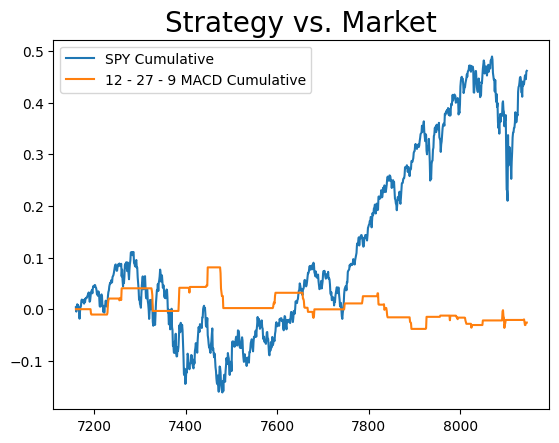

In [4]:
TICKER = 'SPY'
INTERVAL='1d'

# set period based on interval
if INTERVAL == '1h':
    PERIOD = '730d'
else:
    PERIOD = 'max'

MFI_LENGTH = 14
OVERBOUGHT = 60
OVERSOLD = 40
MACD_FAST = 12
MACD_SLOW = 27
MACD_SPAN = 9

# what subsetion of that data are you interested in
LOOKBACK = 1000

def get_data(ticker=TICKER, lookback=LOOKBACK, interval=INTERVAL):

    # get data at interval you want
    df = yf.download(ticker, interval=interval, period=PERIOD)
    df.columns = df.columns.get_level_values(0)

    # reset the index to make plots prettier
    df = df.reset_index(drop=True)

    # only return the subset of data you are interested in
    return df.iloc[-lookback:, :]

def add_MACD(df, fast=MACD_FAST, slow=MACD_SLOW, span=MACD_SPAN):

    df[f'{fast}_ema'] = df['Close'].ewm(span=fast).mean()
    df[f'{slow}_ema'] = df['Close'].ewm(span=slow).mean()

    # macd line is the difference betweent he fast and slow
    df[f'MACD'] = df[f'{fast}_ema'] - df[f'{slow}_ema']

    # macd signal is a 9-period moving average of this line
    df['Signal'] = df['MACD'].ewm(span=span).mean()

    # MACD histogram is almost always what is used in TA
    df['MACD_hist'] = df['MACD'] - df['Signal']

    # plot the histogram
    plt.bar(x=range(len(df)), height=df['MACD_hist'])
    plt.title(f'{MACD_FAST} - {MACD_SLOW} - {MACD_SPAN} MACD Histogram')

    return df

def add_MACD_strategy(df):

    df['MACD_Strategy'] = 0
    df['MACD_Strategy'] = np.where(df['MACD_hist'] > 0, 1, -1)
    df['MACD_Strategy'] = df['MACD_Strategy'].shift(1)
    return df

def add_MFI(df, length=14, overbought=80, oversold=20):
    df = df.copy()

    # Step 1: Calculate typical price
    df['Typical_Price'] = (df['High'] + df['Low'] + df['Close']) / 3

    # Step 2: Calculate raw money flow
    df['Raw_Money_Flow'] = df['Typical_Price'] * df['Volume']

    # Step 3: Classify positive/negative money flow
    df['Price_Change'] = df['Typical_Price'].diff()

    df['Pos_Flow'] = np.where(df['Price_Change'] > 0, df['Raw_Money_Flow'], 0)
    df['Neg_Flow'] = np.where(df['Price_Change'] < 0, df['Raw_Money_Flow'], 0)

    # Step 4: Money Flow Ratio and MFI
    pos_sum = df['Pos_Flow'].rolling(window=length).sum()
    neg_sum = df['Neg_Flow'].rolling(window=length).sum()
    mfr = pos_sum / neg_sum
    df['MFI'] = 100 - (100 / (1 + mfr))

    # Step 5: Plot
    plt.figure()
    plt.plot(df['MFI'], label='MFI')
    plt.axhline(overbought, color='red', linestyle='--', label='Overbought')
    plt.axhline(oversold, color='green', linestyle='--', label='Oversold')
    plt.title('Money Flow Index')
    plt.legend()
    plt.show()

    return df.dropna()

def add_MFI_strategy(df, overbought=OVERBOUGHT, oversold=OVERSOLD):

    df['MFI_Strategy'] = 0
    df['MFI_Strategy'] = np.where(df['MFI'] > overbought, -1, 
                     np.where(df['MFI'] < oversold, 1, 0))
    
    # shift back to make sure we have seen the signal
    df['MFI_Strategy'] = df['MFI_Strategy'].shift(1)
    return df

def add_full_strategy(df):

    df['Full_Strategy'] = df['MACD_Strategy'] + df['MFI_Strategy']

    # adjust values for simplicity
    df['Strategy'] = np.where(df['Full_Strategy'] == 2, 1, 
                     np.where(df['Full_Strategy'] == -2, -1, 0))

    return df

def test_strategy(df):

    df['Asset_Returns'] = (1 + df['Close'].pct_change()).cumprod() - 1
    df['Strategy_Returns'] = (1 + df['Close'].pct_change() * df['Strategy']).cumprod() -1

    plt.figure()
    plt.plot(df['Asset_Returns'])
    plt.plot(df['Strategy_Returns'])
    plt.legend([f'{TICKER} Cumulative', f'{MACD_FAST} - {MACD_SLOW} - {MACD_SPAN} MACD Cumulative'])
    plt.title('Strategy vs. Market', size='20')

    return df

def main():
    df = get_data()
    df = add_MACD(df)
    df = add_MFI(df)
    df = add_MACD_strategy(df)
    df = add_MFI_strategy(df)
    df = add_full_strategy(df)
    df = test_strategy(df)

    return df

df = main()
df